# Dependence of variance of alpha estimate vs 1/T and H

In [1]:
!pip install -q ruptures 
!pip install -q scikit-learn==1.1.3
!pip install -q stochastic
# !pip install -q tensorflow==2.8.0 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 45.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('/kaggle/input/cinnamon/andi_challenge_2_wust-main')

In [4]:
import os
os.chdir('/kaggle/input/cinnamon/andi_challenge_2_wust-main')

In [5]:
import sys
import joblib
import os
import model
from input_utils import get_fovs_of_experiment
from common import State
from ensemble import naive_aggregation, simple_aggregation
from segmentation import analyze_fov, MultiEstimCost, mw_rupture_cp_detection, simple_state_classifier
from estimators import estimate_with_noise_1, estimate_with_noise_3
from _03_characteristics import get_characteristics_new
from submission_utils import create_submission
from cp_detector import CPDetector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from multiprocessing import Pool
import src.deep.tf_dain
THRASHOLD = 0.1
__TRACK_2_PATH = '/kaggle/input/andi2-benchmark-dataset/track_2'
__GRADIENT_BOOSTING_PATH = "/kaggle/input/cinnamon/andi_challenge_2_wust-main/model_alpha_boost_big"

gradient_boosting = joblib.load(__GRADIENT_BOOSTING_PATH)
def alpha_estim_boost(x):
    return gradient_boosting.predict(get_characteristics_new(x).fillna(0))[0]


2025-06-15 11:55:15.031978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749988515.318342      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749988515.399395      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# HurstEE with TensorFlow

In [6]:
import numpy as np
import tensorflow as tf

class HurstEE(tf.keras.layers.Layer):
    def __init__(self, use_correction=False, trim_percent=0, **kwargs):
        """
        Initialization of the HurstEE layer.

        Args:
            use_correction (bool): Whether to apply TEA-MSD&variance correction. Default is False.
            trim_percent (int): Percentage of highest values to trim. Default is 0. DOI 10.1088/2515-7647/adc04e
        """
        super(HurstEE, self).__init__(**kwargs)
        self.use_correction = use_correction
        self.trim_percent = trim_percent

    @staticmethod
    def nanmean(tensor, axis=None, keepdims=False):
        """
        Analog of np.nanmean, ignoring NaN values.

        Args:
            tensor (tf.Tensor): Input tensor.
            axis (int or tuple, optional): Axis or axes along which to compute the mean.
            keepdims (bool, optional): If True, retains reduced dimensions.

        Returns:
            tf.Tensor: Mean value with NaNs ignored.
        """
        mask = ~tf.math.is_nan(tensor)
        masked_tensor = tf.where(mask, tensor, tf.zeros_like(tensor))
        count = tf.reduce_sum(tf.cast(mask, tf.float32), axis=axis, keepdims=keepdims)
        sum_ = tf.reduce_sum(masked_tensor, axis=axis, keepdims=keepdims)
        return sum_ / (count + 1e-8)

    @staticmethod
    def nanstd(tensor, axis=None, keepdims=False):
        """
        Analog of np.nanstd, ignoring NaN values.

        Args:
            tensor (tf.Tensor): Input tensor.
            axis (int or tuple, optional): Axis or axes along which to compute the standard deviation.
            keepdims (bool, optional): If True, retains reduced dimensions.

        Returns:
            tf.Tensor: Standard deviation with NaNs ignored.
        """
        mean_ = HurstEE.nanmean(tensor, axis=axis, keepdims=True)
        sq_diff = tf.square(tensor - mean_)
        var_ = HurstEE.nanmean(sq_diff, axis=axis, keepdims=keepdims)
        return tf.sqrt(var_ + 1e-8)

    @staticmethod
    def trim_array1s(arr, percent):
        """
        Removes a given percentage of the largest values from each row of a 2D tensor, ignoring NaNs.
        
        Args:
            arr (tf.Tensor): Input 2D tensor.
            percent (float): Percentage of values to remove (0 <= percent < 100).

        Returns:
            tf.Tensor: Tensor with values above the threshold replaced by NaN.
        """
        def trim_row(row):
            valid = ~tf.math.is_nan(row)
            valid_values = tf.boolean_mask(row, valid)
            n_valid = tf.shape(valid_values)[0]
            
            def no_valid():
                return row
            
            def do_trim():
                k_float = tf.cast(n_valid, tf.float32) * (percent / 100.0)
                k = tf.cast(tf.round(k_float), tf.int32)
                
                def no_trim():
                    return row
                
                def trim_values():
                    # Sort valid (non-NaN) values in ascending order
                    sorted_valid = tf.sort(valid_values, direction='ASCENDING')
                    # Threshold is the k-th largest value
                    threshold = sorted_valid[-k]
                    # Keep values below threshold, replace others with NaN
                    return tf.where(row < threshold, row, tf.constant(np.nan, dtype=row.dtype))
                
                return tf.cond(tf.equal(k, 0), no_trim, trim_values)
            
            return tf.cond(tf.equal(n_valid, 0), no_valid, do_trim)
        
        return tf.map_fn(trim_row, arr)

    @staticmethod
    def trim_array1s_tea(arr, percent):
        """
        Removes a given percentage of the largest values from the entire tensor, ignoring NaNs.
        The number of elements to remove is based on all non-NaN values.

        Args:
            arr (tf.Tensor): Input tensor.
            percent (float): Percentage of values to remove (0 <= percent < 100).

        Returns:
            tf.Tensor: Tensor with values above the threshold replaced by NaN.
        """
        valid = ~tf.math.is_nan(arr)
        valid_values = tf.boolean_mask(arr, valid)
        n_valid = tf.shape(valid_values)[0]
        
        def no_valid():
            return arr
        
        def do_trim():
            k_float = tf.cast(n_valid, tf.float32) * (percent / 100.0)
            k = tf.cast(tf.round(k_float), tf.int32)
            
            def no_trim():
                return arr
            
            def trim_values():
                sorted_valid = tf.sort(valid_values, direction='ASCENDING')
                threshold = sorted_valid[-k]
                return tf.where(arr < threshold, arr, tf.constant(np.nan, dtype=arr.dtype))
            
            return tf.cond(tf.equal(k, 0), no_trim, trim_values)
        
        return tf.cond(tf.equal(n_valid, 0), no_valid, do_trim)

    def tf_normalize_distribution(self, arr, target_mean, T):
        """
        Normalize the distribution with correction.

        Args:
            arr (tf.Tensor): Input array.
            target_mean (tf.Tensor): Target mean value.
            T (tf.Tensor): Effective time/count indicator.

        Returns:
            tf.Tensor: Normalized array.
        """
        current_mean = self.nanmean(arr)
        current_std = self.nanstd(arr)
        adjustment_term = tf.maximum(current_std**2 - 0.92 / T, 0)**0.5
        standardized = (arr - current_mean) / (current_std + 1e-8)
        return standardized * adjustment_term + target_mean

    def call(self, inputs):
        """
        Forward pass of the layer.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch_size, timesteps, input_channels).

        Returns:
            tf.Tensor: Estimated alpha values.
        """
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]
        input_channels = tf.shape(inputs)[2]

        # Count non-NaN elements across the batch
        not_nan_mask = ~tf.math.is_nan(inputs)
        not_nan_count = tf.reduce_sum(tf.cast(not_nan_mask, tf.float32))

        epsilon = 1e-14
        x_all = inputs
        max_lag = 4
        msds = []
        teamsd_list = []

        # --- Compute MSD and TEA-MSD ---
        for lag in range(1, max_lag + 1):
            displacements = x_all[:, lag:, :] - x_all[:, :-lag, :]
            squared_displacements = tf.square(displacements)
            squared_displacements_sum = tf.reduce_sum(squared_displacements, axis=2)

            # For MSD – trim each row
            msd = self.nanmean(
                self.trim_array1s(squared_displacements_sum, self.trim_percent),
                axis=1
            )
            msds.append(msd)

            # For TEA-MSD – trim the array as a whole
            teamsd_lag = self.nanmean(
                self.trim_array1s_tea(squared_displacements_sum, self.trim_percent)
            )
            teamsd_list.append(teamsd_lag)

        msds = tf.stack(msds, axis=1)             # (batch_size, max_lag)
        teamsd = tf.stack(teamsd_list, axis=0)    # (max_lag,)

        t_lags = tf.range(1, max_lag + 1, dtype=tf.float32)
        log_t_lags = tf.math.log(t_lags + epsilon)

        # --- Compute TEA-MSD alpha ---
        log_teamsd = tf.math.log(teamsd + epsilon)
        mean_x = self.nanmean(log_t_lags)
        mean_x2 = self.nanmean(tf.square(log_t_lags))
        mean_y_teamsd = self.nanmean(log_teamsd)
        mean_xy_teamsd = self.nanmean(log_t_lags * log_teamsd)

        numerator_teamsd = mean_xy_teamsd - mean_x * mean_y_teamsd
        denominator = mean_x2 - mean_x**2
        alpha_teamsd = numerator_teamsd / denominator

        # --- Compute alpha for the batch ---
        log_msds = tf.math.log(msds + epsilon)   # (batch_size, max_lag)
        mean_y = self.nanmean(log_msds, axis=1)  # (batch_size,)
        mean_xy = self.nanmean(log_t_lags * log_msds, axis=1)
        numerator = mean_xy - mean_x * mean_y
        alpha = numerator / denominator          # (batch_size,)

        # --- Replace alpha with NaN if the last MSD < 1e-6 ---
        last_msd = msds[:, -1]  # (batch_size,)
        mask_nan = last_msd < 1e-6
        alpha = tf.where(mask_nan, tf.fill(tf.shape(alpha), np.nan), alpha)

        # --- Compute T based on the number of valid trajectories ---
        valid_mask = ~mask_nan
        valid_count = tf.reduce_sum(tf.cast(valid_mask, tf.float32))
        T = not_nan_count / (valid_count * tf.cast(input_channels, tf.float32))

        # --- Apply normalization correction if enabled ---
        if self.use_correction:
            alpha = self.tf_normalize_distribution(alpha, alpha_teamsd, T)

        # --- Clip alpha to the valid range ---
        H = tf.clip_by_value(alpha, clip_value_min=0.0001, clip_value_max=1.999) / 2

        return H

# HurstEE with PyTorch

In [7]:
import torch
import torch.nn as nn
import numpy as np

class PyHurstEE(nn.Module):
    def __init__(self, use_correction=False, trim_percent=0):
        super(PyHurstEE, self).__init__()
        self.use_correction = use_correction
        self.trim_percent = trim_percent

    @staticmethod
    def nanmean(tensor, dim=None, keepdim=False, eps=1e-8):
        mask = ~torch.isnan(tensor)
        masked = torch.where(mask, tensor, torch.zeros_like(tensor))
        count = mask.sum(dim=dim, keepdim=keepdim).to(tensor.dtype)
        sum_ = masked.sum(dim=dim, keepdim=keepdim)
        return sum_ / (count + eps)

    @staticmethod
    def nanstd(tensor, dim=None, keepdim=False, eps=1e-8):
        mean_ = PyHurstEE.nanmean(tensor, dim=dim, keepdim=True, eps=eps)
        sq_diff = (tensor - mean_)**2
        var = PyHurstEE.nanmean(sq_diff, dim=dim, keepdim=keepdim, eps=eps)
        return torch.sqrt(var + eps)

    @staticmethod
    def trim_array1s(arr, percent):
        rows = []
        for row in arr:
            valid = ~torch.isnan(row)
            vals = row[valid]
            n = vals.numel()
            if n == 0:
                rows.append(row)
                continue
            k = int(round(n * percent / 100.0))
            if k == 0:
                rows.append(row)
                continue
            sorted_vals, _ = torch.sort(vals)
            threshold = sorted_vals[-k]
            trimmed = torch.where(row < threshold, row, torch.tensor(np.nan, device=row.device, dtype=row.dtype))
            rows.append(trimmed)
        return torch.stack(rows, dim=0)

    @staticmethod
    def trim_array1s_tea(arr, percent):
        valid = ~torch.isnan(arr)
        vals = arr[valid]
        n = vals.numel()
        if n == 0:
            return arr
        k = int(round(n * percent / 100.0))
        if k == 0:
            return arr
        sorted_vals, _ = torch.sort(vals)
        threshold = sorted_vals[-k]
        return torch.where(arr < threshold, arr, torch.tensor(np.nan, device=arr.device, dtype=arr.dtype))

    def normalize_distribution(self, arr, target_mean, T, eps=1e-8):
        current_mean = self.nanmean(arr)
        current_std = self.nanstd(arr)
        adjustment = torch.sqrt(torch.clamp(current_std**2 - 0.92 / T, min=0.0))
        standardized = (arr - current_mean) / (current_std + eps)
        return standardized * adjustment + target_mean

    def forward(self, inputs):
        if isinstance(inputs, np.ndarray):
            inputs = torch.from_numpy(inputs).float()
        batch, timesteps, channels = inputs.shape
        not_nan = ~torch.isnan(inputs)
        not_nan_count = not_nan.sum().to(inputs.dtype)

        max_lag = 4
        msds = []
        teamsd_list = []

        for lag in range(1, max_lag + 1):
            disp = inputs[:, lag:, :] - inputs[:, :-lag, :]
            sq = disp**2
            sq_sum = sq.sum(dim=2)

            trimmed = PyHurstEE.trim_array1s(sq_sum, self.trim_percent)
            msd = PyHurstEE.nanmean(trimmed, dim=1)
            msds.append(msd)

            teamsd_arr = PyHurstEE.trim_array1s_tea(sq_sum, self.trim_percent)
            teamsd_lag = PyHurstEE.nanmean(teamsd_arr)
            teamsd_list.append(teamsd_lag)

        msds = torch.stack(msds, dim=1)
        teamsd = torch.stack(teamsd_list)

        eps = 1e-14
        t_lags = torch.arange(1, max_lag+1, dtype=inputs.dtype, device=inputs.device)
        log_t = torch.log(t_lags + eps)

        log_teamsd = torch.log(teamsd + eps)
        mean_x = PyHurstEE.nanmean(log_t)
        mean_x2 = PyHurstEE.nanmean(log_t**2)
        mean_y_tea = PyHurstEE.nanmean(log_teamsd)
        mean_xy_tea = PyHurstEE.nanmean(log_t * log_teamsd)
        num_tea = mean_xy_tea - mean_x * mean_y_tea
        den = mean_x2 - mean_x**2
        alpha_tea = num_tea / den

        log_msds = torch.log(msds + eps)
        mean_y = PyHurstEE.nanmean(log_msds, dim=1)
        mean_xy = PyHurstEE.nanmean(log_t * log_msds, dim=1)
        num = mean_xy - mean_x * mean_y
        alpha = num / den

        last = msds[:, -1]
        mask = last < 1e-6
        alpha = alpha.masked_fill(mask, float('nan'))

        valid = ~mask
        valid_count = valid.sum().to(inputs.dtype)
        T = not_nan_count / (valid_count * channels)

        if self.use_correction:
            alpha = self.normalize_distribution(alpha, alpha_tea, T)

        H = torch.clamp(alpha, min=0.0001, max=1.999) / 2
        return H


In [8]:

import numpy as np
from sklearn.metrics import mean_absolute_error


## RANDI weights

In [9]:
class ta_msd():
    def __init__(self):
        ''' Contains mean squared displacement (MSD) based methods to analyze trajectories.  '''
        
    def trim_array1s(self, arr, percent=0):
        """
        Removes the specified percentage of the largest values from each row of the array, ignoring NaN.
        
        Parameters:
        arr (numpy.ndarray): Input data array.
        percent (float): Percentage of the largest values to remove from each row (0 <= percent < 100).
        
        Returns:
        numpy.ndarray: Array with the largest values removed from each row.
        """
        if not (0 <= percent < 100):
            raise ValueError("The 'percent' parameter must be in the range [0, 100).")
        
        if not isinstance(arr, np.ndarray):
            raise TypeError("Input data must be a numpy array.")
        
        if len(arr) == 0:
            return np.array([])  # Return an empty array if input array is empty
        
        result = np.empty_like(arr, dtype=float)
        
        for i, row in enumerate(arr):
            # Select only non-NaN values from the row
            non_nan_values = row[~np.isnan(row)]
            
            if len(non_nan_values) == 0:
                # If all values in the row are NaN, leave it unchanged
                result[i] = row
                continue
            
            # Sort non-NaN values in ascending order
            sorted_values = np.sort(non_nan_values)
            
            # Calculate the number of elements to remove
            n_non_nan = len(sorted_values)
            k = int(np.ceil(percent / 100 * n_non_nan))  # Number of elements to remove
            
            if k == 0:
                # If there are no elements to remove, copy the row unchanged
                result[i] = row
                continue
            
            # Determine the threshold value for removal
            threshold = sorted_values[-k]
            
            # Create a mask to filter values in the current row
            mask = row <= threshold
            result[i] = np.where(mask, row, np.nan)  # Replace values above the threshold with NaN
        
        return result
    
    def trim_array1s_tea(self, arr, percent=0):
        """
        Removes the specified percentage of the largest values from the entire array, ignoring NaN.
        The number of elements to remove is calculated based on non-NaN values.
        The order of values in each row is preserved.
    
        Parameters:
        arr (numpy.ndarray): Input data array.
        percent (float): Percentage of the largest values to remove (0 <= percent < 100).
    
        Returns:
        numpy.ndarray: Array with the largest values removed.
        """
        if not (0 <= percent < 100):
            raise ValueError("The 'percent' parameter must be in the range [0, 100).")
        
        if not isinstance(arr, np.ndarray):
            raise TypeError("Input data must be a numpy array.")
        
        if len(arr) == 0:
            return np.array([])  # Return an empty array if input array is empty
        
        # Flatten the array to one dimension, ignoring NaN
        flattened = arr[~np.isnan(arr)]
        
        if len(flattened) == 0:
            return arr  # If all values are NaN, return the original array
        
        # Sort the array without NaN
        sorted_values = np.sort(flattened)
        
        # Calculate the number of elements to remove based on non-NaN values
        n_non_nan = len(sorted_values)
        k = int(np.ceil(percent / 100 * n_non_nan))  # Number of elements to remove
        
        if k == 0:
            return arr  # If there are no elements to remove, return the original array
        
        # Determine the threshold value for removal
        threshold = sorted_values[-k] if k > 0 else -np.inf
        
        # Create a mask to filter values
        mask = arr <= threshold
        result = np.where(mask, arr, np.nan)  # Replace values above the threshold with NaN
        
        return result    


    def tamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              method='MSD'
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxDxT (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        tamsd = np.zeros((trajs.shape[0],len(t_lags)), dtype= float)
        for idx, tlag in enumerate(t_lags):
            res1 = np.nanmean(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), axis=-1)
            res4 = np.nanmedian(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), axis=-1)
            res5 = np.nanquantile(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 0.632, axis=-1)
         
            res3 = np.nanmean(self.trim_array1s(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 15), axis=-1) * 1.664

            if method=='MSD':
                    tamsd[:,idx] = res1
            elif method=='MSDt':
                    tamsd[:,idx] = res3
            elif method=='MedianSD':
                    tamsd[:,idx] = res4            
            elif method=='QSD':
                    tamsd[:,idx] = res5     

        return tamsd
        
    def teamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              method='MSD'
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxDxT (N: number of trajectories, D: dimension, T: lenght)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        teamsd = np.zeros((1,len(t_lags)), dtype= float)
        for idx, tlag in enumerate(t_lags):
            res1 = np.nanmean(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1))
            res4 = np.nanmedian(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1))
            res5 = np.nanquantile(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 0.632)
         
            res3 = np.nanmean(self.trim_array1s_tea(((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1), 15)) * 1.664

            if method=='MSD':
                    teamsd[:,idx] = res1
            elif method=='MSDt':
                    teamsd[:,idx] = res3
            elif method=='MedianSD':
                    teamsd[:,idx] = res4            
            elif method=='QSD':
                    teamsd[:,idx] = res5 
        return teamsd    

    def get_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        if not t_lags:
            t_lags = np.arange(1, 5)

        tasmd = self.tamsd(trajs, t_lags) 

        res = np.zeros(trajs.shape[0], dtype= float) 
        for idx, row in enumerate(tasmd):
            if not np.any(np.isnan(row)):
                res[idx] = np.polyfit(t_lags, row, deg = 1)[0] / 4
                # print(idx, np.log(row))
            else:
                res[idx] = np.NaN
                # print('-')
        return res
    
    def get_tea_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        if not t_lags:
            t_lags = np.arange(1, 5)

        teasmd = self.teamsd(trajs, t_lags) 



        if not np.any(np.isnan(teasmd)):
            res = np.polyfit(t_lags, teasmd[0], deg = 1)[0] / 4
            # print(idx, np.log(row))
        else:
            res = np.NaN
            # print('-')
        return res
        
    def get_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None, method='MSD'):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
            
            
        if not t_lags:
            t_lags = np.arange(1, 5)

        tasmd = self.tamsd(trajs, t_lags, method)

        res = np.zeros(trajs.shape[0], dtype= float) 
        for idx, row in enumerate(tasmd):
            if not np.any(np.isnan(row)):
                res[idx] = np.polyfit(np.log(t_lags), np.log(row), deg = 1)[0]
                # print(idx, np.log(row))
            else:
                res[idx] = np.NaN
                # print('-')
        return res       

    def get_tea_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None, method='MSD'):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
            
            
        if not t_lags:
            t_lags = np.arange(1, 5)

        teasmd = self.teamsd(trajs, t_lags, method)



        if not np.any(np.isnan(teasmd)):
            res = np.clip(np.polyfit(np.log(t_lags), np.log(teasmd[0]), deg = 1)[0], 0.001, 1.999)
            # print(idx, np.log(row))
        else:
            res = np.NaN
            # print('-')
        return res

In [10]:
"""
This module have been implemented to compute an Hurst exponent
Estimator using maximum of likelyhood on the periodogram.
It is not a log regression as in Hest_Welp
the  periodogram is the one given by the scipy library
these functions hab been made according to whittlenew,
wittlefunc and fspecFGN of Matlab Biyu_code
"""
import numpy as np
import scipy.optimize as so
from math import gamma


def whittle(data):
    """This function compute the Hurst exponent of a signal using
    a maximum of likelihood on periodogram
    """
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittle_t(data, pointeur, idx):
    """This function compute the Hurst exponent of a signal using
    a maximum of likelihood on periodogram
    the return happend in pointeur[idx]
    """
    nbpoints = len(data)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(data))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    pointeur[idx] = so.fminbound(func, 0, 1)


def whittle_s(data, idx):
    """This function compute the Hurst exponent of a signal data[idx,:]
    using a maximum of likelihood on welch periodogram
    """
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(dataidx))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittle_norm_s(data, idx):
    """This function compute the Hurst exponent of a signal data[idx,:]
    using a maximum of likelihood on periodogram
    the data are normalized which does'nt change anything !
    """
    dataidx = data[idx, :]
    nbpoints = len(dataidx)
    datanorm = (dataidx - np.mean(dataidx)) / np.var(dataidx)
    nhalfm = int((nbpoints - 1) / 2)
    tmp = np.abs(np.fft.fft(datanorm))
    gammahat = np.exp(2 * np.log(tmp[1:nhalfm + 1])) / (2 * np.pi * nbpoints)
    func = lambda Hurst: whittlefunc(Hurst, gammahat, nbpoints)
    return so.fminbound(func, 0, 1)


def whittlefunc(hurst, gammahat, nbpoints):
    """This is the Whittle function
    """
    gammatheo = fspec_fgn(hurst, nbpoints)
    qml = gammahat / gammatheo
    return 2 * (2 * np.pi / nbpoints) * np.sum(qml)


def fspec_fgn(hest, nbpoints):
    """This is the spectral density of a fGN of Hurst exponent hest
    """
    hhest = - ((2 * hest) + 1)
    const = np.sin(np.pi * hest) * gamma(- hhest) / np.pi
    nhalfm = int((nbpoints - 1) / 2)
    dpl = 2 * np.pi * np.arange(1, nhalfm + 1) / nbpoints
    fspec = np.ones(nhalfm)
    for i in np.arange(0, nhalfm):
        dpfi = np.arange(0, 200)
        dpfi = 2 * np.pi * dpfi
        fgi = (np.abs(dpl[i] + dpfi)) ** hhest
        fhi = (np.abs(dpl[i] - dpfi)) ** hhest
        dpfi = fgi + fhi
        dpfi[0] = dpfi[0] / 2
        dpfi = (1 - np.cos(dpl[i])) * const * dpfi
        fspec[i] = np.sum(dpfi)
    fspec = fspec / np.exp(2 * np.sum(np.log(fspec)) / nbpoints)
    return fspec

# TA-MSD Test on FBM Dataset

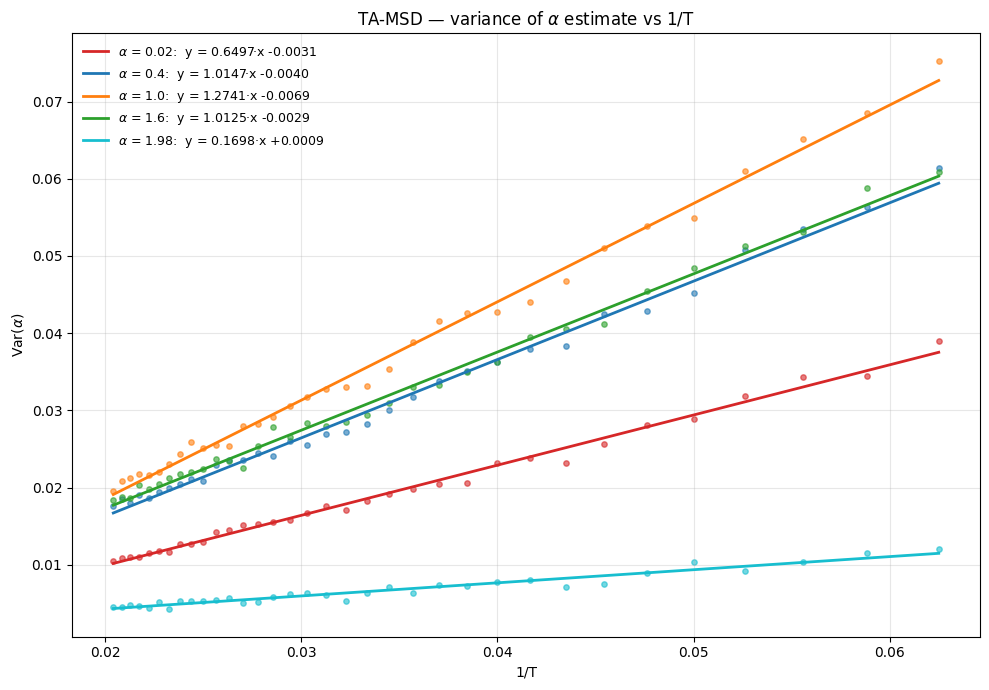

H = 0.01:  slope = 0.6497,  intercept = -0.0031
H = 0.10:  slope = 0.8209,  intercept = -0.0030
H = 0.20:  slope = 1.0147,  intercept = -0.0040
H = 0.35:  slope = 1.1755,  intercept = -0.0045
H = 0.50:  slope = 1.2741,  intercept = -0.0069
H = 0.65:  slope = 1.1982,  intercept = -0.0055
H = 0.80:  slope = 1.0125,  intercept = -0.0029
H = 0.90:  slope = 0.7342,  intercept = -0.0006
H = 0.99:  slope = 0.1698,  intercept = 0.0009
All H:    slope = 0.8944,  intercept = -0.0033


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from stochastic.processes.continuous import FractionalBrownianMotion
from sklearn.linear_model import LinearRegression          # ← новая регрессия
from sklearn.metrics import mean_squared_error

# ---------- генератор FBM-траекторий (N, T, 2) -------------------------------
def simulate_fbm_batch(T, n_traj, hurst):
    """
    FBM-траектории размера (n_traj, T, 2) с показателем Херста hurst.
    """
    T_int = int(T)
    trajs = np.empty((n_traj, T_int, 2), dtype=np.float64)

    for i in range(n_traj):
        fbm_x = FractionalBrownianMotion(hurst=hurst, t=T_int - 1)
        fbm_y = FractionalBrownianMotion(hurst=hurst, t=T_int - 1)

        # sample(T_int - 1) → T точек (0 … T-1)
        trajs[i, :, 0] = fbm_x.sample(T_int - 1)   # X
        trajs[i, :, 1] = fbm_y.sample(T_int - 1)   # Y

    return trajs



def draw_plot():
    # Parameters -------------------------------------------------------------
    H_values = [0.01, 0.1, 0.2, 0.35, 0.50, 0.65, 0.8, 0.9, 0.99]
    H_values_plot = [0.01,  0.2,  0.50,  0.8,  0.99]    
    colours  = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:cyan']
    n_traj   = 3000
    T_values = np.arange(16, 50)          # trajectory lengths
    inv_T    = 1.0 / T_values             # x-axis: 1/T

    msd_tool = ta_msd()                   # your TA-MSD analyser

    # Containers
    var_dict   = {}       # Var(alpha) for each H
    param_dict = {}       # (slope, intercept) for each H

    # --- individual regressions -------------------------------------------
    for H in H_values:
        variances = np.empty_like(inv_T)
        for k, T in enumerate(T_values):
            trajs   = simulate_fbm_batch(T, n_traj, H)   # shape (N, T, 2)
            alphas  = msd_tool.get_exponent(trajs)       # shape (N,)
            variances[k] = np.var(alphas, ddof=1)        # Var(alpha)

        model = LinearRegression()                       # intercept=True
        model.fit(inv_T.reshape(-1, 1), variances)

        var_dict[H]   = variances.copy()
        param_dict[H] = (model.coef_[0], model.intercept_)

    # --- joint regression (all H together) ---------------------------------
    all_x = np.tile(inv_T, len(H_values)).reshape(-1, 1)
    all_y = np.concatenate([var_dict[h] for h in H_values])
    joint_model = LinearRegression().fit(all_x, all_y)
    joint_slope  = joint_model.coef_[0]
    joint_inter  = joint_model.intercept_

    # --- plotting ----------------------------------------------------------
    plt.figure(figsize=(10, 7))

    for H, colour in zip(H_values_plot, colours):
        slope, inter = param_dict[H]
        plt.scatter(inv_T, var_dict[H], s=15, alpha=0.6, color=colour)
        plt.plot(inv_T, slope * inv_T + inter,
                 color=colour, lw=2,
                 label=rf'$\alpha$ = {H*2}:  y = {slope:.4f}·x {inter:+.4f}')


    plt.xlabel('1/T')
    plt.ylabel(r'Var($\alpha$)')
    plt.title(r'TA-MSD — variance of $\alpha$ estimate vs 1/T')
    plt.legend(frameon=False, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- console summary ---------------------------------------------------
    for H in H_values:
        slope, inter = param_dict[H]
        print(f'H = {H:.2f}:  slope = {slope:.4f},  intercept = {inter:.4f}')
    print(f'All H:    slope = {joint_slope:.4f},  intercept = {joint_inter:.4f}')

draw_plot()

# Whittle Test on FBM Dataset

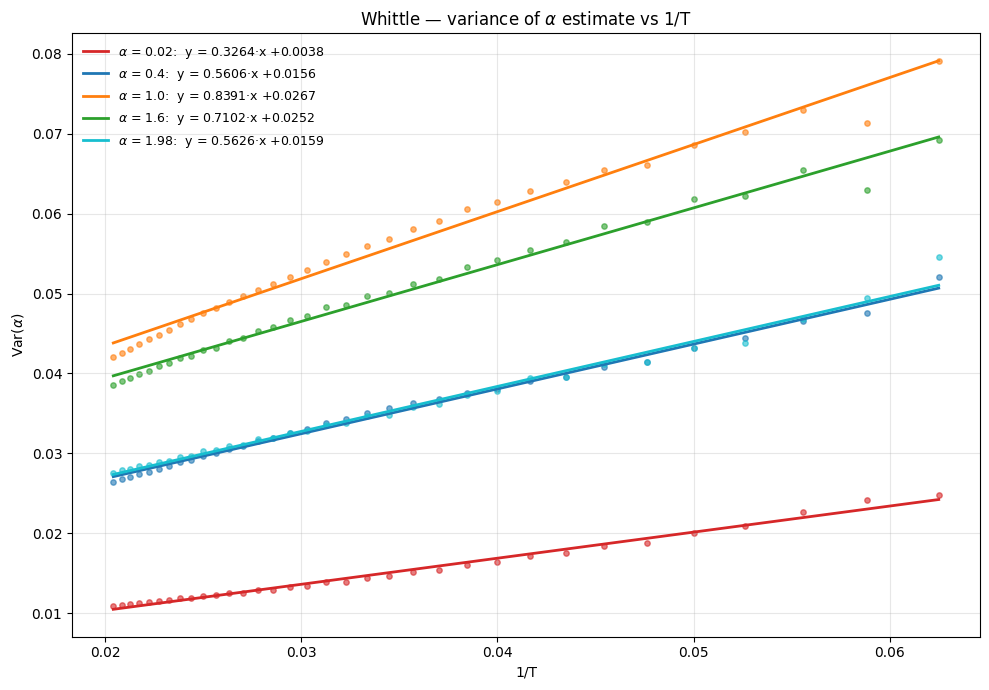

H = 0.01:  slope = 0.3264,  intercept = 0.0038
H = 0.10:  slope = 0.4155,  intercept = 0.0101
H = 0.20:  slope = 0.5606,  intercept = 0.0156
H = 0.35:  slope = 0.7471,  intercept = 0.0231
H = 0.50:  slope = 0.8391,  intercept = 0.0267
H = 0.65:  slope = 0.9049,  intercept = 0.0256
H = 0.80:  slope = 0.7102,  intercept = 0.0252
H = 0.90:  slope = 0.5413,  intercept = 0.0228
H = 0.99:  slope = 0.5626,  intercept = 0.0159
All H:    slope = 0.6231,  intercept = 0.0188


In [12]:
def draw_plot():
    # Parameters -------------------------------------------------------------
    H_values = [0.01, 0.1, 0.2, 0.35, 0.50, 0.65, 0.8, 0.9, 0.99]
    H_values_plot = [0.01,  0.2,  0.50,  0.8,  0.99]    
    colours  = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:cyan']
    n_traj   = 1000
    T_values = np.arange(16, 50)          # trajectory lengths
    inv_T    = 1.0 / T_values             # x-axis: 1/T

    msd_tool = ta_msd()                   # your TA-MSD analyser
    
    # Containers
    var_dict   = {}       # Var(alpha) for each H
    param_dict = {}       # (slope, intercept) for each H

    # --- individual regressions -------------------------------------------
    for H in H_values:
        variances = np.empty_like(inv_T)
        alphas = []
        for k, T in enumerate(T_values):
            trajs   = simulate_fbm_batch(T, n_traj, H)   # shape (N, T, 2)
            dif = trajs[:,1:,:] - trajs[:,:-1,:]
            for tr in dif:
                alphas.append(whittle(tr[:,0]) +  whittle(tr[:,1]))      # shape (N,)
            variances[k] = np.var(alphas, ddof=1)        # Var(alpha)

        model = LinearRegression()                       # intercept=True
        model.fit(inv_T.reshape(-1, 1), variances)

        var_dict[H]   = variances.copy()
        param_dict[H] = (model.coef_[0], model.intercept_)

    # --- joint regression (all H together) ---------------------------------
    all_x = np.tile(inv_T, len(H_values)).reshape(-1, 1)
    all_y = np.concatenate([var_dict[h] for h in H_values])
    joint_model = LinearRegression().fit(all_x, all_y)
    joint_slope  = joint_model.coef_[0]
    joint_inter  = joint_model.intercept_

    # --- plotting ----------------------------------------------------------
    plt.figure(figsize=(10, 7))

    for H, colour in zip(H_values_plot, colours):
        slope, inter = param_dict[H]
        plt.scatter(inv_T, var_dict[H], s=15, alpha=0.6, color=colour)
        plt.plot(inv_T, slope * inv_T + inter,
                 color=colour, lw=2,
                 label=rf'$\alpha$ = {H*2}:  y = {slope:.4f}·x {inter:+.4f}')



    plt.xlabel('1/T')
    plt.ylabel(r'Var($\alpha$)')
    plt.title(r'Whittle — variance of $\alpha$ estimate vs 1/T')
    plt.legend(frameon=False, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- console summary ---------------------------------------------------
    for H in H_values:
        slope, inter = param_dict[H]
        print(f'H = {H:.2f}:  slope = {slope:.4f},  intercept = {inter:.4f}')
    print(f'All H:    slope = {joint_slope:.4f},  intercept = {joint_inter:.4f}')

draw_plot()

# CINNAMON Test on FBM Dataset

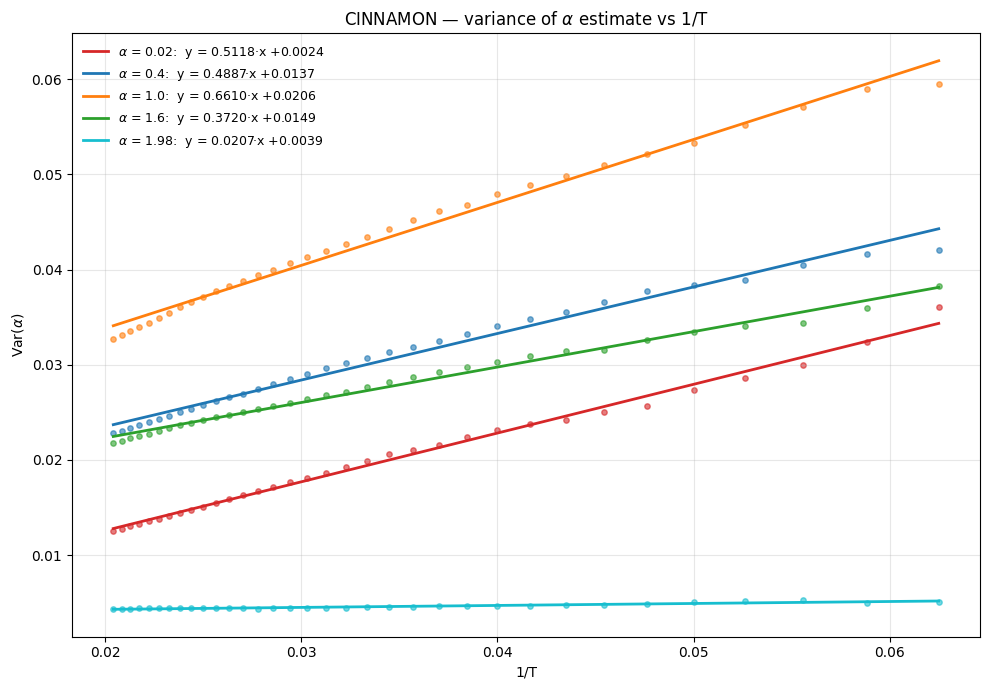

H = 0.01:  slope = 0.5118,  intercept = 0.0024
H = 0.10:  slope = 0.4205,  intercept = 0.0065
H = 0.20:  slope = 0.4887,  intercept = 0.0137
H = 0.35:  slope = 0.7132,  intercept = 0.0182
H = 0.50:  slope = 0.6610,  intercept = 0.0206
H = 0.65:  slope = 0.5428,  intercept = 0.0200
H = 0.80:  slope = 0.3720,  intercept = 0.0149
H = 0.90:  slope = 0.2383,  intercept = 0.0088
H = 0.99:  slope = 0.0207,  intercept = 0.0039
All H:    slope = 0.4410,  intercept = 0.0121


In [13]:
def draw_plot():
    # Parameters -------------------------------------------------------------
    H_values = [0.01, 0.1, 0.2, 0.35, 0.50, 0.65, 0.8, 0.9, 0.99]
    H_values_plot = [0.01,  0.2,  0.50,  0.8,  0.99]    
    colours  = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:cyan']
    n_traj   = 1000
    T_values = np.arange(16, 50)          # trajectory lengths
    inv_T    = 1.0 / T_values             # x-axis: 1/T

    msd_tool = ta_msd()                   # your TA-MSD analyser
    
    # Containers
    var_dict   = {}       # Var(alpha) for each H
    param_dict = {}       # (slope, intercept) for each H

    # --- individual regressions -------------------------------------------
    for H in H_values:
        variances = np.empty_like(inv_T)
        alphas = []
        for k, T in enumerate(T_values):
            trajs   = simulate_fbm_batch(T, n_traj, H)   # shape (N, T, 2)
            for tr in trajs:
                alphas.append(alpha_estim_boost(tr))      # shape (N,)
            variances[k] = np.var(alphas, ddof=1)        # Var(alpha)

        model = LinearRegression()                       # intercept=True
        model.fit(inv_T.reshape(-1, 1), variances)

        var_dict[H]   = variances.copy()
        param_dict[H] = (model.coef_[0], model.intercept_)

    # --- joint regression (all H together) ---------------------------------
    all_x = np.tile(inv_T, len(H_values)).reshape(-1, 1)
    all_y = np.concatenate([var_dict[h] for h in H_values])
    joint_model = LinearRegression().fit(all_x, all_y)
    joint_slope  = joint_model.coef_[0]
    joint_inter  = joint_model.intercept_

    # --- plotting ----------------------------------------------------------
    plt.figure(figsize=(10, 7))

    for H, colour in zip(H_values_plot, colours):
        slope, inter = param_dict[H]
        plt.scatter(inv_T, var_dict[H], s=15, alpha=0.6, color=colour)
        plt.plot(inv_T, slope * inv_T + inter,
                 color=colour, lw=2,
                 label=rf'$\alpha$ = {H*2}:  y = {slope:.4f}·x {inter:+.4f}')



    plt.xlabel('1/T')
    plt.ylabel(r'Var($\alpha$)')
    plt.title(r'CINNAMON — variance of $\alpha$ estimate vs 1/T')
    plt.legend(frameon=False, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- console summary ---------------------------------------------------
    for H in H_values:
        slope, inter = param_dict[H]
        print(f'H = {H:.2f}:  slope = {slope:.4f},  intercept = {inter:.4f}')
    print(f'All H:    slope = {joint_slope:.4f},  intercept = {joint_inter:.4f}')

draw_plot()